# TIF345/FYM345: Project 3: A Galton board on a rocking ship

# Names 
Jonatan Haraldsson [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

Jesper Noord [noord@chalmers.se](mailto:noord@chalmers.se)

In [696]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import sklearn
import pandas as pd
import emcee
import numpy as np
import random
import tqdm
from tqdm import trange
import keras as keras
import tensorflow as tf

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

sns.set_palette('deep')
from matplotlib import cbook, cm
from seaborn import cm
from matplotlib.colors import LightSource
# plot in separate window
%matplotlib inline

rng = np.random.default_rng(seed = 42)

### Importing and massaging data

In [651]:
board_data = np.load('board_data.npy')

board_df = pd.DataFrame(board_data, columns = [f'bin_{i}' for i in range(32)])

display(board_df)


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,bin_31
0,0.0,0.0,0.0,2.0,5.0,9.0,11.0,28.0,31.0,47.0,...,8.0,8.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,...,78.0,59.0,57.0,34.0,26.0,7.0,6.0,2.0,1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,8.0,19.0,18.0,27.0,47.0,...,11.0,5.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,13.0,57.0,79.0,85.0,116.0,109.0,119.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,88.0,54.0,70.0,28.0,25.0,14.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,76.0,75.0,54.0,36.0,26.0,11.0,2.0,3.0,0.0,0.0
9996,2.0,47.0,60.0,107.0,113.0,109.0,121.0,117.0,100.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9.0,29.0,63.0,81.0,115.0,121.0,131.0,112.0,99.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,99.0,87.0,85.0,84.0,48.0,30.0,12.0,3.0,0.0


### Plots

Referring to the classical case with a Galton board, where the bead has an equal probability of bouncing to the left or the right, the distribution will converge to a binomial distribution for $N_\text{samples} \rightarrow\infty$.

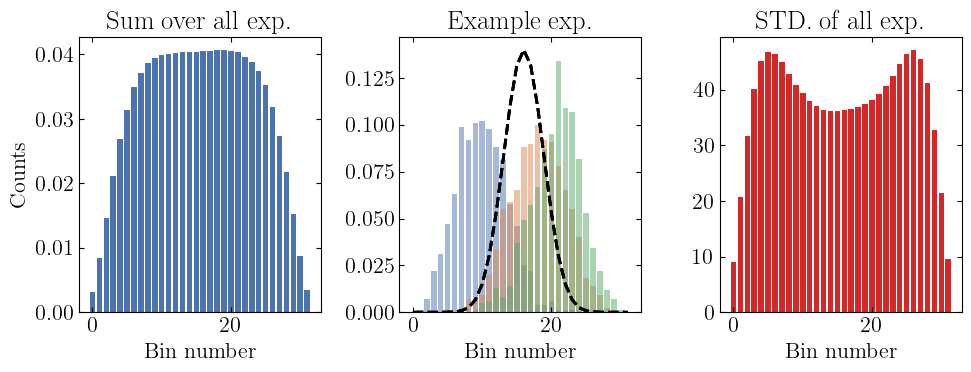

In [652]:

fig, ax = plt.subplots(1,3,figsize = (10, 4))

ax[0].bar(np.arange(32), board_data.sum(axis=0) / board_data.sum())
ax[0].set_xlabel('Bin number')
ax[0].set_ylabel('Counts')


for n in range(3):
    i = rng.integers(0, board_data.shape[0])
    ax[1].bar(np.arange(32), board_data[i]/ board_data[i].sum(),alpha=0.5)
    ax[1].plot(scipy.stats.binom.pmf(np.arange(32), n=32, p=1/2), color='black', lw=2,ls = '--')

ax[1].set_xlabel('Bin number')
ax[1].set_title('Example exp.')
ax[0].set_title('Sum over all exp.')
ax[2].set_title('STD. of all exp.')
ax[2].bar(np.arange(32), np.std(board_data,axis=0),color='tab:red')
ax[2].set_xlabel('Bin number')
plt.tight_layout()

plt.show()

In [653]:
def p_peg(alpha,s,left=None):
    if left == None:
        M = 0.
    elif left:
        M = 0.5
    else:
        M = -0.5
    return 0.5 + (alpha * M + s)

def p_peg_vec(alpha,s,left):
    M = np.zeros_like(left)
    M[left == True] = 0.5
    M[left == False] = -0.5
    p = 0.5 + (alpha * M + s)
    return p
    
def simulator(alpha,s, N=int(1e3)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(32)

    left_bounces = np.zeros(32)
    left_ = np.zeros((N,32))


    for i in range(31):
        r = np.random.uniform(0,1,N)
        if i == 0:
            left_[:,i] = r <= (0.5 + s)
        else:
            left_[:,i] = r < p_peg_vec(alpha,s,left=left_[:,i-1])   
    left_bounces = np.sum(left_, axis=1)
    for bounces in left_bounces:
        bin_counts[int(bounces)] += 1
    return bin_counts 

32
32


<BarContainer object of 32 artists>

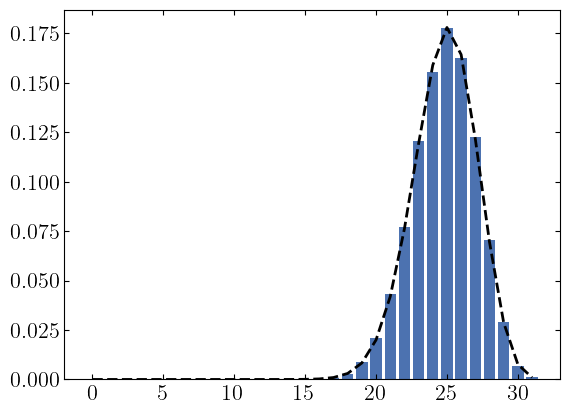

In [654]:
alpha = 0
s = 0.3
res = simulator(alpha,s,N=int(1e4))


#ind = np.argmax(res)


P = scipy.stats.binom.pmf(np.arange(32), n=31, p=p_peg(alpha,s))
plt.plot(P, color='black', lw=2,ls = '--')
print(len(P))

print(len(res))
plt.bar(np.arange(32), res/res.sum()) 

In [655]:
def statistic(data):
    x = np.arange(len(data))
    data = data / np.sum(data)
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, np.sqrt(var)

In [656]:
alphas = np.linspace(0,0.5,11)
ss = np.linspace(-0.25,0.25,11)
means = np.zeros((len(alphas), len(ss)))
variances = np.zeros((len(alphas), len(ss)))
for i, alpha in enumerate(alphas):
    for j, s in enumerate(ss):
        res = simulator(alpha,s)
        mean, var = statistic(res)
        means[i,j] = mean
        variances[i,j] = var

In [657]:
def grid_gen(xlim, ylim, size=50):
    x = np.linspace(xlim[0], xlim[1], size)
    y = np.linspace(ylim[0], ylim[1], size)
    X, Y = np.meshgrid(x, y)
    return X, Y


def contour_generator(xlim, ylim, size=50):
    X, Y = grid_gen(xlim, ylim, size)
    Z1 = np.zeros_like(X)
    Z2 = np.zeros_like(X)

    for i in trange(X.shape[0]):
        for j in range(X.shape[1]):
            res = simulator(X[i, j], Y[i, j])
            mean, var = statistic(res)
            Z1[i, j] = mean
            Z2[i, j] = var
    return X, Y, Z1, Z2

In [658]:
A,S,MEAN,STD = contour_generator((0,0.5),(-0.25,0.25),size=100)

100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


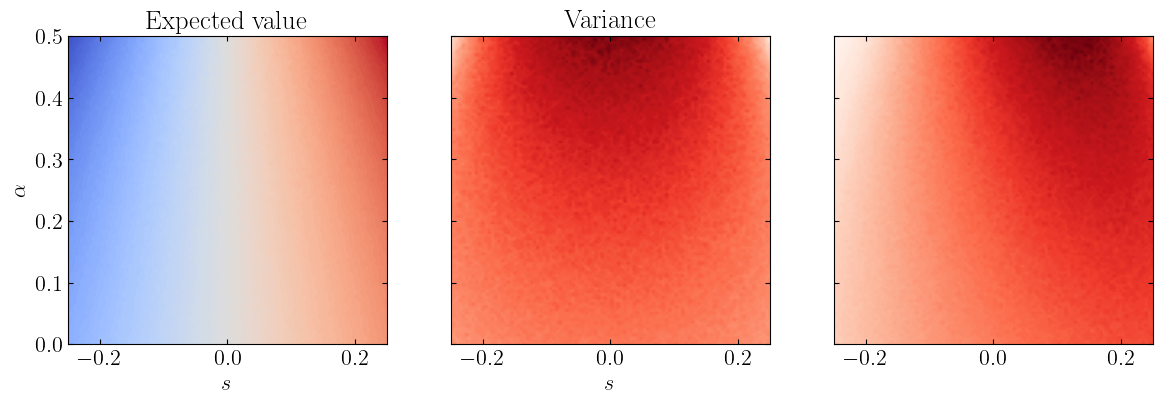

In [659]:
fig,ax = plt.subplots(1,3,figsize=(14,4),sharey=True) 
conf0 = ax[0].contourf(S,A , MEAN/ np.max(MEAN), levels=100, cmap='coolwarm')
#ax[0].contour(A, S, Z, levels=100, c='k',alpha =0.5)
conf1 = ax[1].contourf(S, A, STD / np.max(STD) , levels=100, cmap='Reds')
ax[0].set_title('Expected value')
ax[1].set_title('Variance')
ax[0].set_ylabel(r'$\alpha$')
ax[0].set_xlabel(r'$s$')
ax[1].set_xlabel(r'$s$')
conf2 = ax[2].contourf(S, A, STD * MEAN, levels=100, cmap='Reds')

#fig.colorbar(conf0, ax=ax[0],label='Exp')
#fig.colorbar(conf1, ax=ax[1],label='Std. dev')#'$\\mathbb{COV}$ [eV$^2$]')
#fig.colorbar(conf2, ax=ax[2],label='Std. dev')#'$\\mathbb{COV}$ [eV$^2$]')

#plt.savefig('contour_plots.pdf', bbox_inches='tight')



In [660]:
def generate_data(N_samples):
    train_data = np.zeros((N_samples,32))
    target_data = np.zeros((N_samples,2))
    for n in trange(N_samples):
        s = np.random.uniform(-0.25,0.25)
        a = np.random.uniform(0,0.5)
        train_data[n,:] = simulator(a,s)
        target_data[n,0] = a
        target_data[n,1] = s
    return train_data, target_data
    

def generate_data_mesh(N_samples):
    train_data = np.zeros((N_samples**2,32))
    target_data = np.zeros((N_samples**2,2))
    s = np.random.uniform(-0.25,0.25,N_samples)
    a = np.random.uniform(0,0.5,N_samples)
    A,S = np.meshgrid(a,s)
    A = A.ravel()
    S = S.ravel()
    for n in trange(N_samples**2):
        train_data[n,:] = simulator(A[n],S[n])
        target_data[n,0] = A[n]
        target_data[n,1] = S[n]
    return train_data, target_data


# train_data, target_data = generate_data(50000)
# np.save('train_data.npy', train_data)
# np.save('target_data.npy', target_data)

In [661]:
data = np.load('train_data_1.npy')
target = np.load('target_data_1.npy')

In [662]:
def kernel(y_pred, y_obs):
    sq = []
    D = []
    h = 5
    for i in range(len(y_pred)):
        diff = (statistic(y_pred[i,:].ravel())[0] - statistic(y_obs.ravel())[0]) / h
        sq.append(diff**2)
        D.append(diff)
    SQ = np.array(sq)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))

In [663]:
def kernel(N, A, S, y_obs, mode='mean',h=5, h_std=5):
    sq = np.zeros(N)
    for i in range(N):
        if mode == 'mean':
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[0] - statistic(y_obs.ravel())[0]
            diff = diff**2 / h
        elif mode == 'std':   
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[1] - statistic(y_obs.ravel())[1]
            diff = diff**2 / h_std
        elif mode == 'both':
            sim_mean, sim_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) 
            true_mean, true_std = np.array(statistic(y_obs.ravel()))
            diff  = 1/h * (sim_mean - true_mean )**2 + 1/h_std * (sim_std - true_std )**2
        elif mode == 'idea':
            sim_mean, sim_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) 
            true_mean, true_std = np.array(statistic(y_obs.ravel()))
            diff  = 1/h * (sim_mean - true_mean )**2 /(sim_mean * true_mean) + 1/h_std * (sim_std - true_std )**2/(sim_std * true_std)
        elif mode == 'normal':
            diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
            diff = ((diff_mean**2 / h) / diff_std**2)
        else:
            raise ValueError("Mode must be 'mean', 'std', 'both' or 'normal'")
        sq[i] = diff
    return sq

In [664]:
def kernel_pred(y_obs,N=1000,h=1, mode = 'mean'):
    S = np.random.uniform(-0.25,0.25,N)
    A = np.random.uniform(0,0.5,N)
    #a = np.linspace(0,0.5,int(np.sqrt(N)))
    #s = np.linspace(-0.25,0.25,int(np.sqrt(N)))
    #A,S = np.meshgrid(a,s)
    #A = A.ravel()
    #S = S.ravel()
    h_std = h/4
    # for i in trange((N)):
    #     if mode == 'mean':
    #         diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[0] - statistic(y_obs.ravel())[0]
    #         diff = diff**2 / h
    #         D.append(diff)
    #     elif mode == 'std':   
    #         diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[1] - statistic(y_obs.ravel())[1]
    #         diff = diff**2 / h_std
    #         D.append(diff)
    #     elif mode == 'both':
    #         diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
    #         diff = np.sqrt(diff_mean**2/h**2 + diff_std**2 / h_std**2)
    #         D.append(diff)
    #     elif mode == 'normal':
    #         diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
    #         diff = ((diff_mean**2 / h) / diff_std**2)
    #         D.append(diff)
    #     else:
    #         raise ValueError("Mode must be 'mean', 'std', 'both' or 'normal'")
    #     sq.append(diff)
    
    SQ = kernel(N, A, S, y_obs, mode=mode,h=h, h_std=h_std)
    return np.sqrt(SQ), (np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))),A,S

In [665]:
def joint_plot(x,y,x_name,y_name):
    d = pd.DataFrame(np.vstack((x,y)).T,columns=[f'{x_name}',f'{y_name}'])
    #sns.jointplot(data=d, x=x_name, y=y_name, kind='kde', fill=True, cmap='Blues')
    g = sns.jointplot(data = d, x =x_name,y =y_name,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
    for coll in list(g.ax_joint.collections):
        coll.remove()
    g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
    g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

In [753]:
def weighted_quantile(x, w, q):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    w = w / np.sum(w)

    idx = np.argsort(x)
    x_sorted = x[idx]
    w_sorted = w[idx]

    cdf = np.cumsum(w_sorted)
    return np.interp(q, cdf, x_sorted)

def weighted_ci(x, w, conf_level=0.95):
    alpha = 1.0 - conf_level
    lo = weighted_quantile(x, w, alpha/2)
    hi = weighted_quantile(x, w, 1 - alpha/2)
    return lo, hi

def corner_plot(a,s,P,t_obs):
    bins = 30
    a = a.ravel()
    s = s.ravel()
    P = P.ravel()
    fig, ax = plt.subplots(2,2,figsize=(7,5.75),sharex='col', sharey='row')
    #ax[1,1].hist(s,bins=bins,weights=P,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
    ax[1,1].hist(s,bins=int(bins *1.5),weights=P,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
    ax[0,0].hist(a,bins=bins,weights=P,edgecolor='black', alpha=0.7,density=True,orientation='vertical')

    s_mean = np.sum(s * P)
    a_mean = np.sum(a * P)

    ax[0,0].axvline(a_mean,color='tab:green',label='Mean for $\\alpha$ and $s$')
    ax[1,1].axhline(s_mean,color='tab:green')

    ax[1,0].axvline(a_mean,color='tab:green')
    ax[1,0].axhline(s_mean,color='tab:green')
    if t_obs is not None:
        ax[1,0].axhline(t_obs[1],color='tab:red',alpha = 0.4, label='Observed $\\alpha$ and $s$')
        ax[1,0].axvline(t_obs[0],color='tab:red',alpha = 0.4)
        ax[0,0].axvline(t_obs[0],color='tab:red',alpha = 0.4)
        ax[1,1].axhline(t_obs[1],color='tab:red',alpha = 0.4)

    ax[0,1].axis('off')
    s_lo, s_hi = weighted_ci(s, P, 0.68)
    a_lo, a_hi = weighted_ci(a, P, 0.68)
    ax[1,0].axhline(s_lo,  color='black', linewidth=1, ls='--',label =f'68\% CI \n $s\,\\in[{s_lo:.2f}, {s_hi:.2f}]$\n $\\alpha\\in[{a_lo:.2f}, {a_hi:.2f}]$')
    ax[1,1].axhline(s_lo,  color='black', linewidth=1, ls='--')
    ax[1,0].axhline(s_hi, color='black', lw=1, ls='--')
    ax[1,1].axhline(s_hi, color='black', lw=1, ls='--')
    ax[1,0].axvline(a_lo, color='black', lw=1, ls='--')
    ax[0,0].axvline(a_lo, color='black', lw=1, ls='--')
    ax[1,0].axvline(a_hi, color='black', lw=1, ls='--')
    ax[0,0].axvline(a_hi, color='black', lw=1, ls='--')
    
    ax[1,0].hist2d(a,s,bins=bins, weights=P, cmap='Blues')
    ax[1,0].set_ylabel('$s$')
    ax[1,0].set_xlabel('$\\alpha$')
    ax[1,0].set_ylim(0,0.25)
    ax[1,0].set_xticks(np.arange(0.1,0.5,0.1))
    
    fig.legend(bbox_to_anchor=(0.9, 0.9)    )
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    return fig, ax

<>:46: SyntaxWarning: invalid escape sequence '\%'
<>:46: SyntaxWarning: invalid escape sequence '\%'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/3185942731.py:46: SyntaxWarning: invalid escape sequence '\%'
  ax[1,0].axhline(s_lo,  color='black', linewidth=1, ls='--',label =f'68\% CI \n $s\,\\in[{s_lo:.2f}, {s_hi:.2f}]$\n $\\alpha\\in[{a_lo:.2f}, {a_hi:.2f}]$')


In [759]:
t_obs = np.array([0.3,0.15])
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

D,P,a,s = kernel_pred(y_obs,N=1000,h=0.25,mode = 'mean')   # Difference in summary statistics  # Kernel size / Probability

Observed parameters: alpha = 0.3, s = 0.15


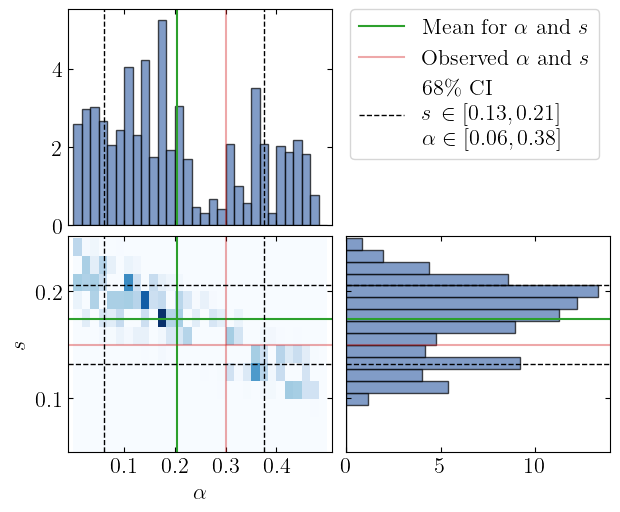

In [ ]:
fig,ax = corner_plot(a,s,P,t_obs)
ax[1,0].set_ylim(0.05,0.251)
ax[1,0].set_xlim(-0.01,0.51)

#plt.savefig('figs/corner_ABC.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Combined kernel')

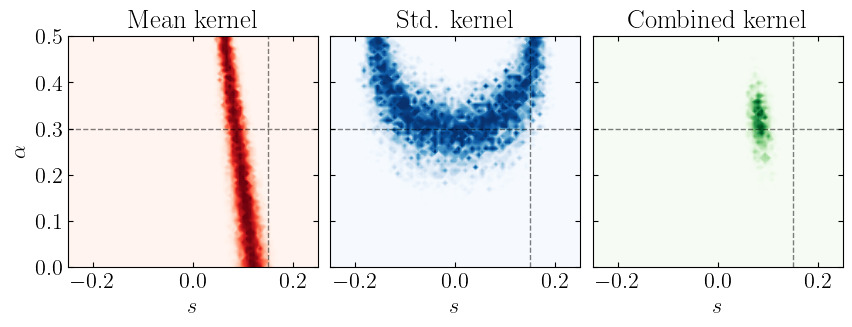

In [620]:
fig, ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
#N_grid = int(np.sqrt(1000))
N_grid = 75

#t_obs = np.array([0.1,-0.15])
#y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))

S = np.linspace(-0.25,0.25,N_grid)
A = np.linspace(0,0.5,N_grid)
A_grid, S_grid = np.meshgrid(A,S)

h = 0.25; h_s = 0.025

#h = 1; h_s = 0.001;


Z = kernel(len(S_grid.ravel()), A_grid.ravel(), S_grid.ravel(), y_obs, mode='mean', h=h,h_std = h_s)
Z = Z.reshape(A_grid.shape)
Z_mean = np.exp(-0.5 * (Z)) / np.sum(np.exp(-0.5 * (Z)))
conf = ax[0].contourf(S_grid, A_grid, Z_mean, levels=100, cmap='Reds')


Z = kernel(len(S_grid.ravel()), A_grid.ravel(), S_grid.ravel(), y_obs, mode='std', h=h,h_std = h_s)
Z = Z.reshape(A_grid.shape)
Z_std = np.exp(-0.5 * (Z)) / np.sum(np.exp(-0.5 * (Z)))
conf = ax[1].contourf(S_grid, A_grid, Z_std, levels=100, cmap='Blues')

Z = kernel(len(S_grid.ravel ()), A_grid.ravel(), S_grid.ravel(), y_obs, mode='both', h=h,h_std = h_s)
Z = Z.reshape(A_grid.shape)
Z_both = np.exp(-0.5 * (Z)) / np.sum(np.exp(-0.5 * (Z)))
conf = ax[2].contourf(S_grid, A_grid, Z_both, levels=100, cmap='Greens')
fig.subplots_adjust(wspace=0.05, hspace=0.05)
ax[0].set_ylabel(r'$\alpha$')
ax[0].set_xlabel(r'$s$')
ax[1].set_xlabel(r'$s$')
ax[2].set_xlabel(r'$s$')
ax[0].axhline(t_obs[0],color='black', lw=1, ls='--',alpha = 0.5)
ax[0].axvline(t_obs[1],color='black', lw=1, ls='--',alpha = 0.5)
ax[1].axhline(t_obs[0],color='black', lw=1, ls='--',alpha = 0.5)
ax[1].axvline(t_obs[1],color='black', lw=1, ls='--',alpha = 0.5)
ax[2].axhline(t_obs[0],color='black', lw=1, ls='--',alpha = 0.5)
ax[2].axvline(t_obs[1],color='black', lw=1, ls='--',alpha = 0.5)
ax[0].set_title('Mean kernel')
ax[1].set_title('Std. kernel')
ax[2].set_title('Combined kernel')
#plt.savefig('figs/abc_kernel_comparison.pdf', bbox_inches='tight')


## Neural Network

In [557]:
fraction_train = 0.70; fraction_test = 0.10; fraction_valid = 1. - fraction_train - fraction_test

data_train = data[:int(fraction_train*len(data))]
target_train = target[:int(fraction_train*len(target))]

data_test = data[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(data))]
target_test = target[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(target))]

data_valid = data[int((fraction_train+fraction_test)*len(data)):]
target_valid = target[int((fraction_train+fraction_test)*len(target)):]

print(f"Training and target data size: {len(data_train)} x {len(target_train)} ")
print(f"Testing and target data size: {len(data_test)} x {len(target_test)} ")
print(f"Validation and target data size: {len(data_valid)} x {len(target_valid)} ")

Training and target data size: 35000 x 35000 
Testing and target data size: 5000 x 5000 
Validation and target data size: 10000 x 10000 


In [727]:
model = keras.models.Sequential([   
    keras.layers.Dense(64, activation='tanh', input_shape=(32,)),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(2,activation='tanh')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [728]:
model.compile(
  optimizer='adam',
  loss='mse',metrics=['accuracy'])

In [729]:
epochs = 150     ## Number of epoch to run
batch_size = 32  ## Mini batch size

es = keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights = True)
# Train the model.
history = model.fit(
  data_train, target_train,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  callbacks=[es],
  validation_data=(data_valid, target_valid))

Epoch 1/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.8730 - loss: 0.0226 - val_accuracy: 0.9359 - val_loss: 0.0027
Epoch 2/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.9386 - loss: 0.0024 - val_accuracy: 0.9434 - val_loss: 0.0020
Epoch 3/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.9456 - loss: 0.0019 - val_accuracy: 0.9349 - val_loss: 0.0017
Epoch 4/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - accuracy: 0.9529 - loss: 0.0016 - val_accuracy: 0.9511 - val_loss: 0.0013
Epoch 5/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.9525 - loss: 0.0014 - val_accuracy: 0.9451 - val_loss: 0.0015
Epoch 6/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - accuracy: 0.9538 - loss: 0.0013 - val_accuracy: 0.9583 - val_loss: 0.0011
Epoch 7/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.9566 - loss: 0.0011 - val_accuracy: 0.9500 - val_loss: 0.0012
Epoch 8/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 

In [730]:
predictions = model.predict(data_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


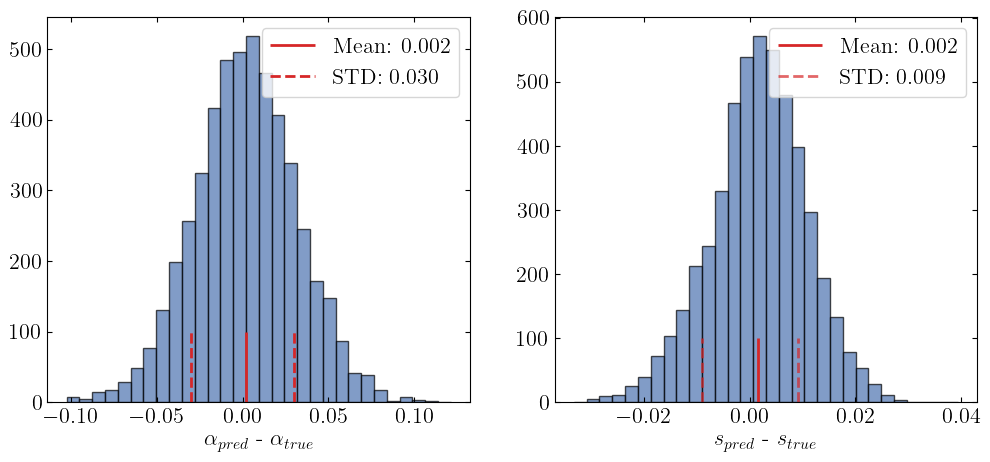

In [731]:
dif = predictions[:,0] - target_test[:,0]
dif1 = predictions[:,1] - target_test[:,1]

fig, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].hist(predictions[:,0] - target_test[:,0],bins = 30 ,edgecolor='black', alpha=0.7)
ax[0].vlines(np.mean(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: {np.mean(dif):.3f}')
ax[0].vlines(np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--', label = f'STD: {np.std(dif):.3f}')
ax[0].vlines(-np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--')
ax[0].set_xlabel('$\\alpha_{pred}$ - $\\alpha_{true}$')


ax[1].hist(predictions[:,1] - target_test[:,1],bins = 30,edgecolor='black', alpha=0.7)
ax[1].vlines(np.mean(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: ${np.mean(predictions[:,1] - target_test[:,1]):.3f}$')
ax[1].vlines(np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7, label = f'STD: ${np.std(predictions[:,1] - target_test[:,1]):.3f}$')
ax[1].vlines(-np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7)
ax[1].set_xlabel('$s_{pred}$ - $s_{true}$')
ax[0].legend()
ax[1].legend()



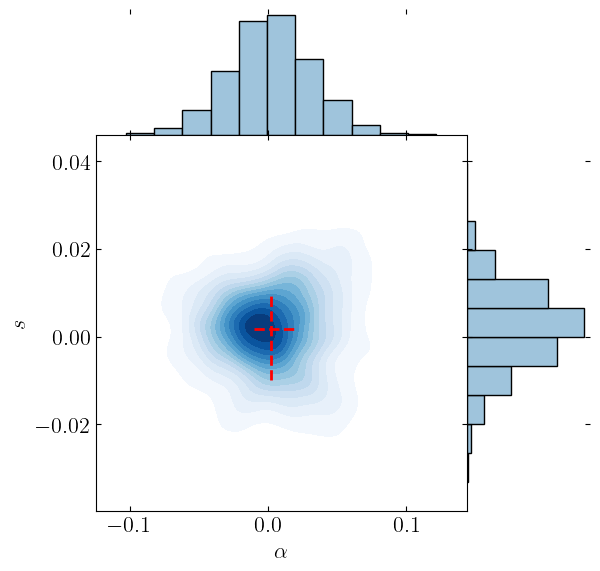

In [732]:

data = pd.DataFrame(np.vstack((dif,dif1)).T,columns=[r"$\alpha$",r'$s$'])
x = r'$\alpha$'; y = '$s$'
#sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'kde',fill = True,cmap='Blues', levels = 15)#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
g = sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
for coll in list(g.ax_joint.collections):
    coll.remove()
g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

plt.vlines(np.mean(dif), -0.01, 0.01, color='red', lw=2, ls='--')
plt.hlines(np.mean(dif1), -0.01, 0.02, color='red', lw=2, ls='--')
#plt.vlines(0.5, -0.25, 0.25, color='red', lw=2, ls='--')
#plt.hlines(-0.25, 0, 0.5, color='red', lw=2, ls='--')
#plt.hlines(0.25, 0, 0.5, color='red', lw=2, ls='--')
plt.show()

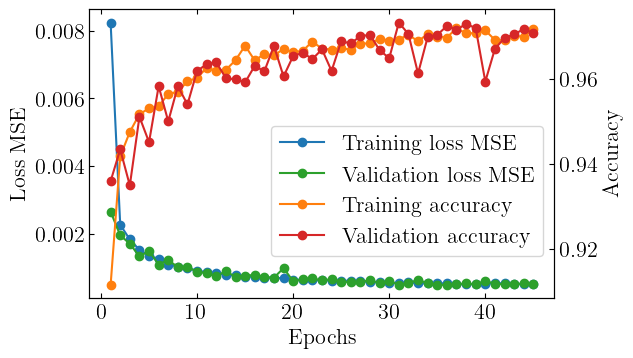

In [764]:
epochrange = range(1, len(history.history['loss']) + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#plt.plot(epochrange, train_acc, 'bo', label='Training acc')
#plt.plot(epochrange, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy (modell 1)')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
fig, ax = plt.subplots(figsize=(6, 3.75))

ax1 = ax.twinx()
ax.plot(epochrange, train_loss, '-o',color = 'tab:blue', label='Training loss MSE')
ax.plot(epochrange, val_loss, '-o',color = 'tab:green', label='Validation loss MSE')
ax1.plot(epochrange, accuracy, '-o',color = 'tab:orange', label='Training accuracy')
ax1.plot(epochrange, val_accuracy, '-o',color = 'tab:red', label='Validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss MSE')   
ax1.set_ylabel('Accuracy')   
fig.legend(bbox_to_anchor=(0.9, 0.6),ncol = 1)
plt.savefig('figs/training_validation_history.pdf', bbox_inches='tight')

In [734]:
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))
preds = model.predict(np.array([y_obs]))
print(f'Predicted parameters: alpha = {preds[0,0]}, s = {preds[0,1]}')  
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted parameters: alpha = 0.2755465805530548, s = 0.1506291776895523
Observed parameters: alpha = 0.3, s = 0.15


## ABC NN


In [ ]:
# def colonel_NN(model, y_obs, N=100, h=1, mode=None):
#     sq = []
#     D = []
#     a = np.random.uniform(0,0.5,int(N))
#     s = model.predict(np.array([y_obs]))[0,1] + np.random.normal(0.003,0.009,int(N))

#     for i in trange((N)):
#         if mode == 'mean':
#             diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[0] - statistic(y_obs.ravel())[0]
#         elif mode == 'std':   
#             diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[1] - statistic(y_obs.ravel())[1]
#         elif mode == 'both':
#             diff_mean, diff_std= np.array(statistic(simulator(alpha =a[i], s =s[i]).ravel())) - np.array(statistic(y_obs.ravel()))
#             diff = np.sqrt(diff_mean**2 + diff_std**2)
#         else:
#             raise ValueError("Mode must be 'mean', 'std', or 'both'")
#         sq.append(diff**2 / h)
#         D.append(diff)
#     SQ = np.array(sq)
#     D = np.array(D)
#     return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ))),a,s

In [742]:
def colonel_NN(model, y_obs, N=1000, h=1, mode = 'mean'):
    a = np.random.uniform(0,0.5,int(N))
    s = model.predict(np.array([y_obs]))[0,1] + np.random.normal(0.00,0.009,int(N))
    #s = model.predict(np.array([y_obs]))[0,1] * np.ones(N)
    print(f'Mean s from NN: {np.mean(s)}')
    SQ = kernel(N, a, s, y_obs, mode=mode,h=h)
    D = np.sqrt(SQ)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ))),a,s

In [743]:
D_NN,P_NN,a_nn,s_nn = colonel_NN(model, y_obs,N=1000,h=0.25,mode = 'mean')   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean s from NN: 0.15060949021430065


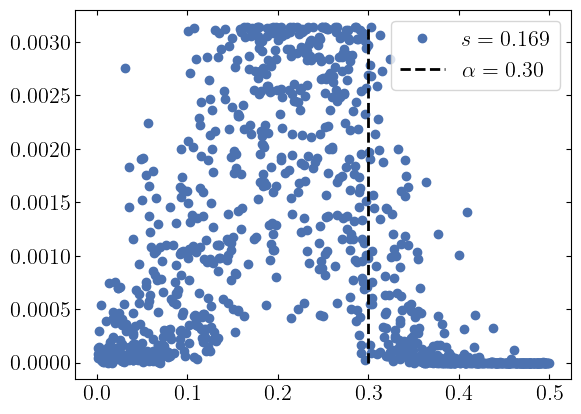

In [721]:
plt.plot(a_nn,P_NN,'o',label=f'$s = {s_nn[0]:.3f}$')
plt.vlines(t_obs[0], 0, np.max(P_NN), color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
plt.legend()

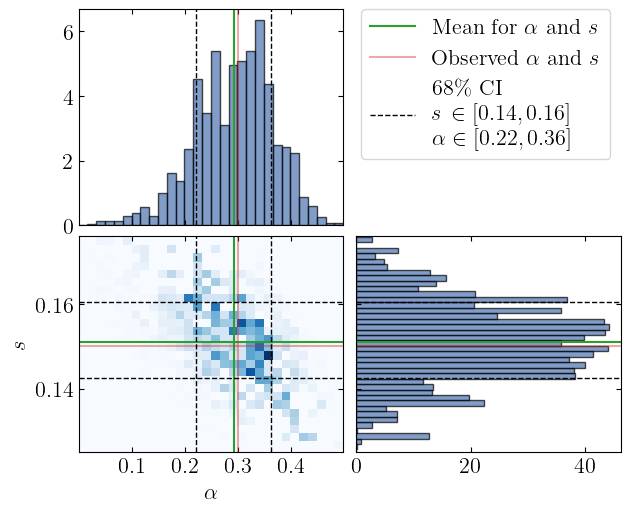

In [754]:
fig, ax = corner_plot(a_nn,s_nn,P_NN,t_obs)
ax[1,0].set_ylim(0.125,0.176) 

plt.savefig('figs/corner_NN_ABC.pdf', bbox_inches='tight')

## Chain of posterior

In [ ]:
def statistic_2(data,x):
    data = data / np.sum(data)
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, np.sqrt(var)

def kernel_chain(y_obs,N=500,N_chain = 5, h=1, mode=None):
    for j in trange(N_chain):
        sq = []
        D = []
        if j == 0: 
            s = np.random.uniform(-0.25,0.25,int(N))
            a = np.random.uniform(0,0.5,int(N))
        else:
            mu_s = statistic_2(P,s)[0]
            std_s = statistic_2(P,s)[1]
            mu_a = statistic_2(P,a)[0]
            std_a = statistic_2(P,a)[1] 
            s = scipy.stats.norm.rvs(mu_s, std_s, int(N))
            a = scipy.stats.norm.rvs(mu_a, std_a, int(N))
            #print(f'Chain {j}: mu_a = {mu_a}, std_a = {std_a}, mu_s = {mu_s}, std_s = {std_s}')

        SQ = kernel(N, a, s, y_obs, mode=mode,h=h)
        D = np.sqrt(SQ)
        # for i in range((N)):
        #     if mode == 'mean':
        #         diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[0] - statistic(y_obs.ravel())[0]
        #     elif mode == 'std':   
        #         diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[1] - statistic(y_obs.ravel())[1]
        #     elif mode == 'both':
        #         diff_mean, diff_std= np.array(statistic(simulator(alpha =a[i], s =s[i]).ravel())) - np.array(statistic(y_obs.ravel()))
        #         diff = np.sqrt(diff_mean**2 + diff_std**2)
        #     else:
        #         raise ValueError("Mode must be 'mean', 'std', or 'both'")
        #     sq.append(diff**2 / h)
        #     D.append(diff)
        # SQ = np.array(sq)
        # D = np.array(D)
        P = np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))
    return D, P,a,s

In [610]:
D_c,P_c,a_c,s_c = kernel_chain(y_obs,N_chain = 250,N=1000,h=0.25,mode = 'mean')   

 75%|███████▌  | 188/250 [02:41<00:53,  1.16it/s]


KeyboardInterrupt: 

Observed parameters: alpha = 0.3, s = 0.2


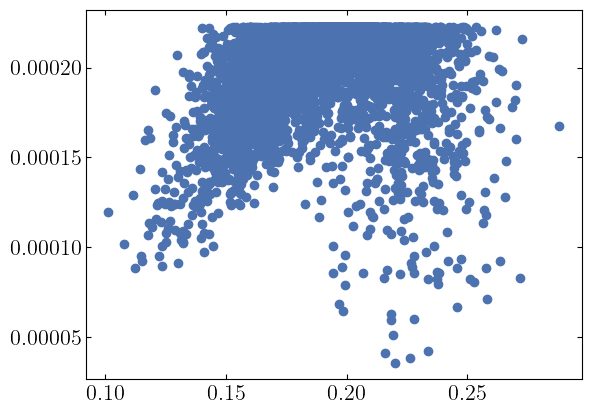

In [ ]:
plt.plot(s_c,P_c,'o',label=f'$s = {s_nn[0]:.3f}$')
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

#joint_plot(a_c,s_c,'$\\alpha$','$s$')

/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/3208258025.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0,0].legend()
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/3208258025.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,1].legend()


Observed parameters: alpha = 0.3, s = 0.2


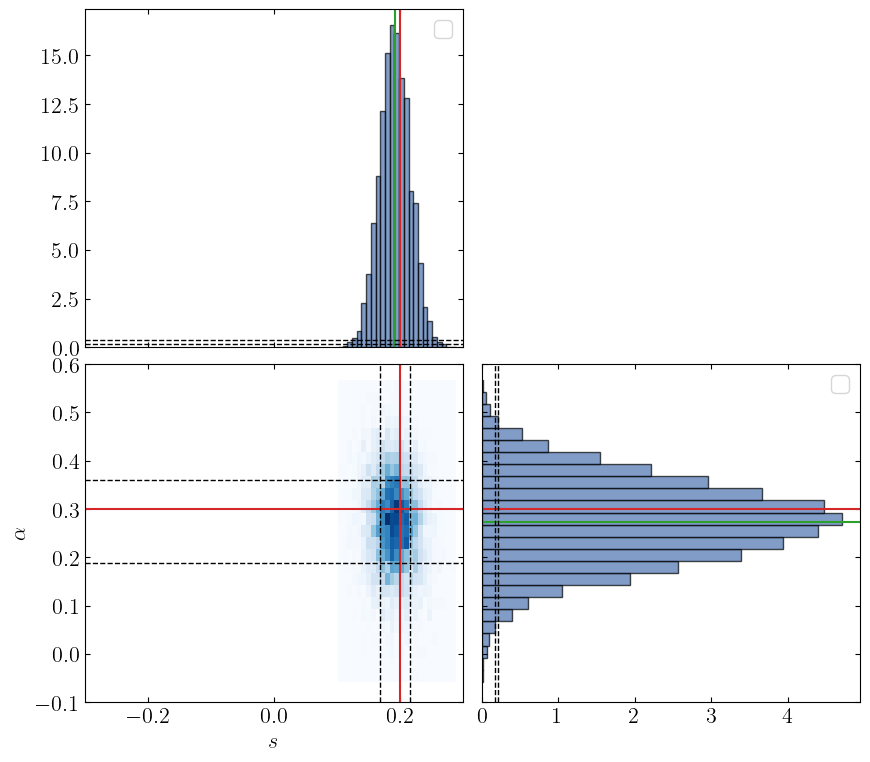

In [ ]:

bins = 25
fig, ax = plt.subplots(2,2,figsize=(10,9),sharex='col', sharey='row')
ax[0,0].hist(s_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='vertical')
ax[1,1].hist(a_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
ax[1,0].axhline(t_obs[0],color='tab:red')
ax[1,0].axvline(t_obs[1],color='tab:red')

s_mean = np.sum(s_c * P_c)
a_mean = np.sum(a_c * P_c)

ax[1,1].axhline(a_mean,color='tab:green')
ax[0,0].axvline(s_mean,color='tab:green')

ax[1,1].axhline(t_obs[0],color='tab:red')
ax[0,0].axvline(t_obs[1],color='tab:red')



s_lo, s_hi = weighted_ci(s_c, P_c, 0.68)
a_lo, a_hi = weighted_ci(a_c, P_c, 0.68)
ax[1,0].axvline(s_lo,  color='black', linewidth=1, ls='--')
ax[1,1].axvline(s_lo,  color='black', linewidth=1, ls='--')

ax[1,0].axvline(s_hi, color='black', lw=1, ls='--')
ax[1,1].axvline(s_hi, color='black', lw=1, ls='--')

ax[1,0].axhline(a_lo, color='black', lw=1, ls='--')
ax[0,0].axhline(a_lo, color='black', lw=1, ls='--')

ax[1,0].axhline(a_hi, color='black', lw=1, ls='--')
ax[0,0].axhline(a_hi, color='black', lw=1, ls='--')




ax[0,1].axis('off')

print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

ax[0,0].legend()
ax[1,1].legend()

ax[1,0].hist2d(s_c,a_c,bins=bins, weights=P_c, cmap='Blues')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')
ax[1,0].set_xlim([-0.3,0.3])
ax[1,0].set_ylim([-0.1,0.6])
#plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('abc_posterior.pdf', bbox_inches='tight')

TypeError: 'Axes' object is not subscriptable

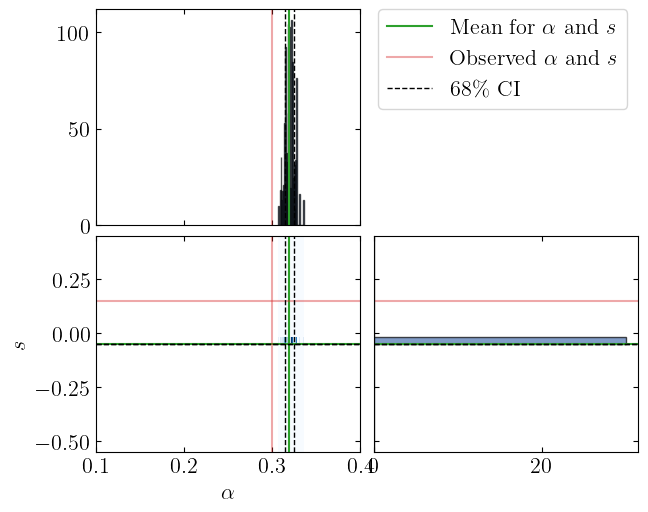

In [ ]:
fig, ax = corner_plot(a_c,s_c,P_c,t_obs)
ax[1,0].set_xlim([-0.1,0.6])
#plt.savefig('figs/abc_chain_corner.pdf', bbox_inches='tight')

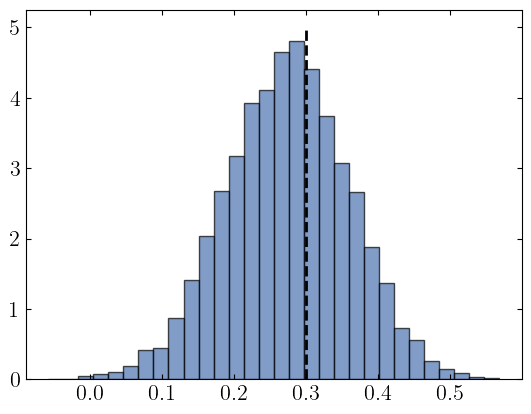

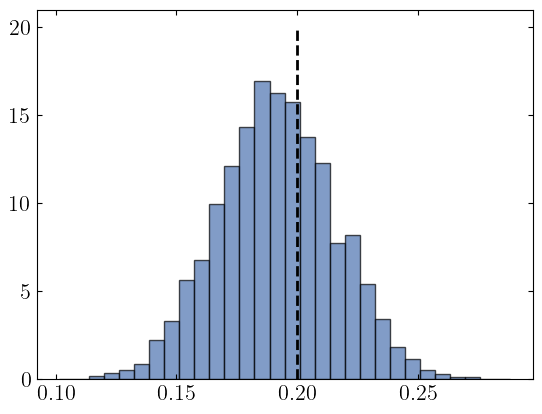

In [ ]:
plt.hist(a_c,bins=30,weights=P_c,edgecolor='black', alpha=0.7,density=True)#,weights=P_§c,edgecolor='black', alpha=0.7)
plt.vlines(t_obs[0], 0, 5, color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
plt.show()
plt.hist(s_c,bins=30,weights=P_c,edgecolor='black', alpha=0.7,density=True)#,weights=P_§c,edgecolor='black', alpha=0.7)
plt.vlines(t_obs[1], 0, 20, color='black', lw=2, ls='--',label=f'$s = {t_obs[1]:.2f}$')
plt.show()

In [611]:
def kernel_chain_nn(Y_obs,N=500,N_chain = 5, h=1, mode=None,model = model):
    rng = np.random.default_rng(seed=42)
    k = rng.uniform(0,1,N_chain) * len(Y_obs)
    k = k.astype(int)
    A = np.zeros((N_chain,2))
    A_NN = []
    for j in trange(N_chain):
        y_obs = Y_obs[k[j],:].ravel()
        s = model.predict(np.array([y_obs]),verbose = 0)[0,1] * np.ones(N) #+ scipy.stats.norm.rvs(-0.003,0.009)
        
        A_NN.append(model.predict(np.array([y_obs]),verbose = 0)[0,0])

        if j == 0: 
            a = np.random.uniform(0,0.5,int(N))
            A[j,0] = np.mean(a)
            A[j,1]  = np.std(a)
        else:
            mu_a = statistic_2(P,a)[0]
            std_a = statistic_2(P,a)[1] 
            A[j,0] = mu_a
            A[j,1] = std_a
            #print(A[j,:])
            a = scipy.stats.norm.rvs(mu_a, std_a, int(N))
            #print(f'Chain {j}: mu_a = {mu_a}, std_a = {std_a}')
            #print(f'{j}\t{A_NN[j]}\t{mu_a}')
        SQ = kernel(N, a, s, y_obs, mode=mode,h=h)
        P = np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))
    return np.sqrt(SQ), P,A,s, A_NN,a

In [612]:
yy = simulator(0.1,0.1)
print(model.predict(np.array([yy]),verbose = 0)[0,0])

0.09584808


NN prediction: alpha = 0.33578047156333923, s = 0.07531005889177322


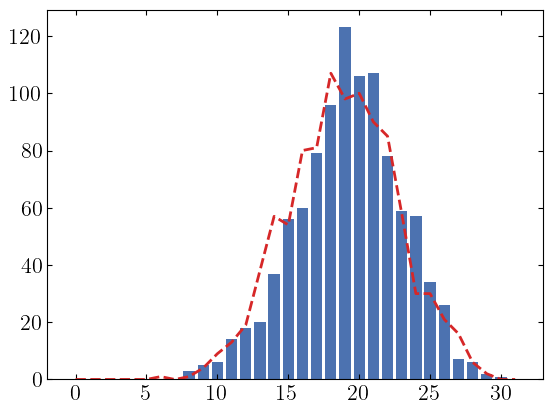

In [613]:
Y = np.load('board_data.npy') 

y_obs = Y[1,:].ravel()
a_nn,s  = model.predict(np.array([y_obs]),verbose = 0)[0,:]
print(f'NN prediction: alpha = {a_nn}, s = {s}')

plt.bar(np.arange(32), y_obs)
res = simulator(a_nn,s)
plt.plot(res, color='tab:red', lw=2, ls='--')



In [ ]:
D_c,P_c,A,s_c, A_NN, a_c = kernel_chain_nn(Y,N_chain = 250,N=1000,h = 0.25,mode = 'mean')   

100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


NN estimate: alpha = 0.3174307346343994 ± 0.021839402616024017


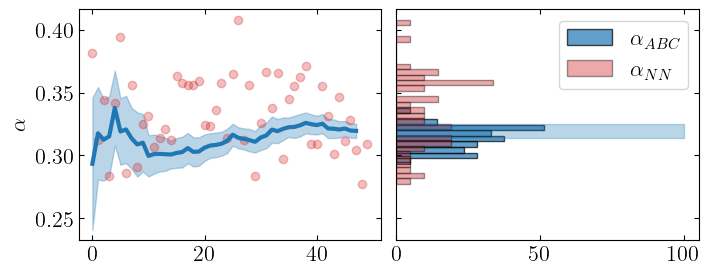

In [640]:
frac = 2
fig, ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
ax[0].plot(A_NN,'o',color='tab:red', label=f'$\\alpha_{{NN}}$',alpha = 0.3)
ax[0].plot(A[frac:,0],color = 'tab:blue',lw = 3)
ax[0].fill_between(np.arange(len(A[frac:,0])), A[frac:,0]+A[frac:,1], A[frac:,0]-A[frac:,1], alpha=0.3,color = 'tab:blue')

ax[1].hist(A[frac:,0],bins = 10,orientation = 'horizontal',edgecolor='black', alpha=0.7,density=True, color ='tab:blue', label = f'$\\alpha_{{ABC}}$')
ax[1].hist(A_NN[frac:],bins = 30,orientation = 'horizontal',edgecolor='black', alpha=0.4,density=True, color ='tab:red',label = f'$\\alpha_{{NN}}$')
fig.subplots_adjust(wspace=0.05, hspace=0.05)
ax[0].set_ylabel('$\\alpha$')
ax[1].legend()
ax[1].fill_between([0,100],  A[-1,0]+A[-1,1], A[-1,0]-A[-1,1], color='tab:blue', alpha=0.3)
print(f'NN estimate: alpha = {np.mean(A_NN[-10:])} ± {np.std(A_NN[-10:])}')
#plt.hlines(A_NN,0,len(A_c[:,0]), color='tab:red', lw=2, ls='--',label=f'$\\alpha_{{NN}}$')
plt.savefig('figs/abc_nn_chain.pdf', bbox_inches='tight')

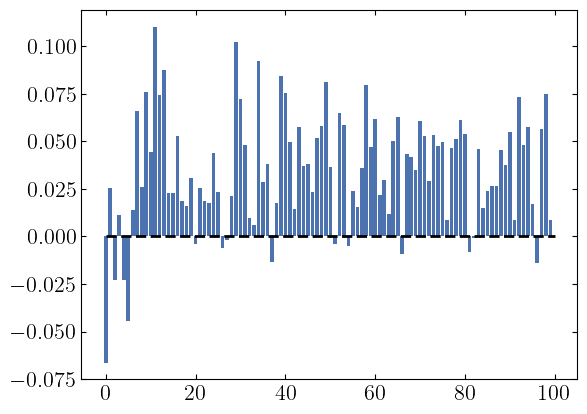

In [ ]:
plt.bar(np.arange(len(A)),A[:,0] - A_NN[:])

plt.hlines(0,0,len(A[:,0]), color='black', lw=2, ls='--')


/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/1487695443.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


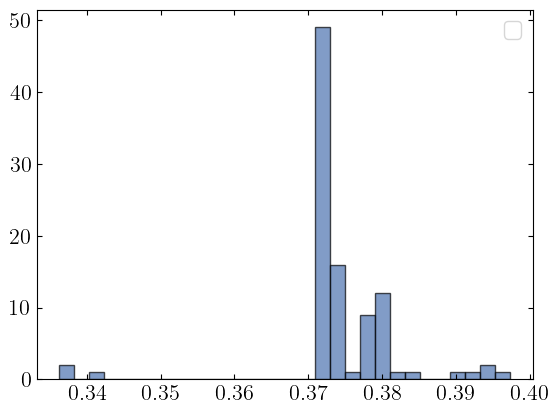

In [ ]:
plt.hist(A[frac:,0], bins=30, edgecolor='black', alpha=0.7)
#plt.vlines(0,0,50, color='black', lw=2, ls='--')
#plt.vlines(np.mean(A[:,0]- A_NN[:]),0,50, color='tab:red', lw=2, ls='-', label=f'Mean: {np.mean(A[:,0]- A_NN[:]):.3f}')
plt.legend()

(50,) (50,) (50,)


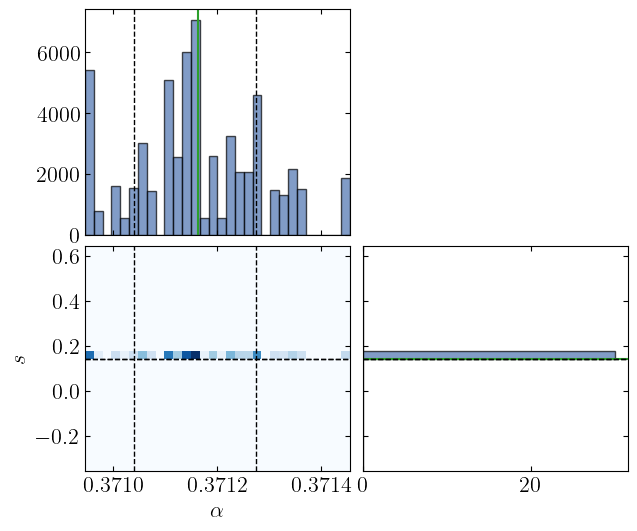

In [ ]:

print(a_c.shape,s_c.shape,P_c.shape)
corner_plot(a_c,s_c,P_c,t_obs = None)

/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/535032170.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0,0].legend()
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/535032170.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,1].legend()


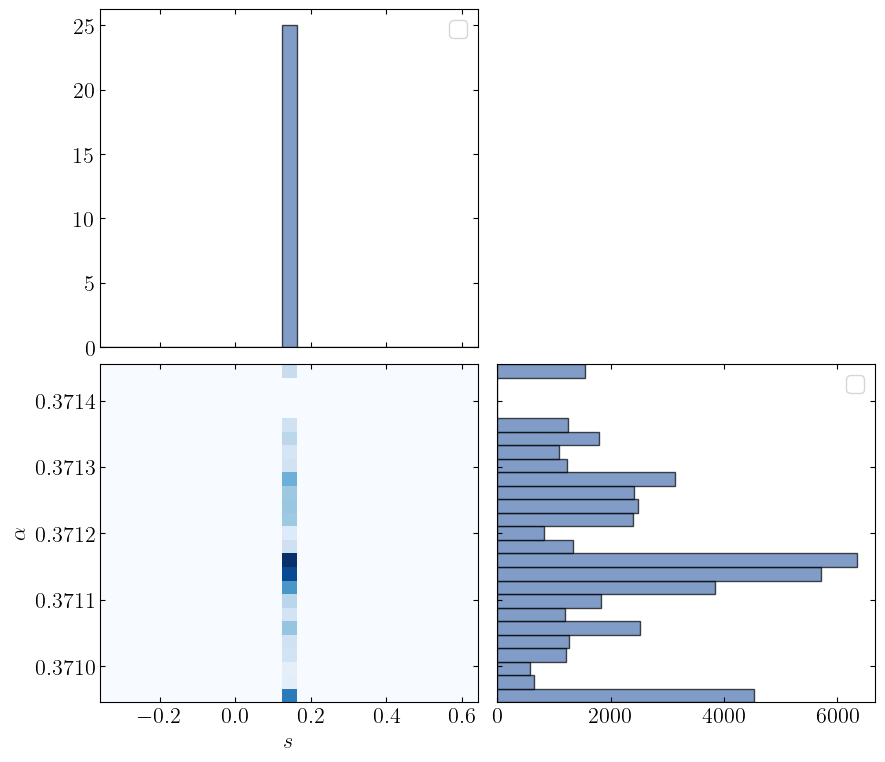

In [ ]:

bins = 25
s_c = np.array(s_c)
fig, ax = plt.subplots(2,2,figsize=(10,9),sharex='col', sharey='row')
s_c = s_c.ravel()
P_c = P_c.ravel()
a_c = a_c.ravel()



ax[0,0].hist(s_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='vertical')
ax[1,1].hist(a_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
#ax[1,0].axhline(t_obs[0],color='tab:red')
#ax[1,0].axvline(t_obs[1],color='tab:red')
s_lo, s_hi = weighted_ci(s_c, P_c, 0.68)
a_lo, a_hi = weighted_ci(a_c, P_c, 0.68)

s_mean = np.sum(s_c * P_c)
a_mean = np.sum(a_c * P_c)

#ax[1,1].axhline(a_mean,color='tab:green')
#ax[0,0].axvline(s_mean,color='tab:green')

#ax[1,1].axhline(t_obs[0],color='tab:red')
#ax[0,0].axvline(t_obs[1],color='tab:red')



#ax[1,0].axvline(s_lo,  color='black', linewidth=1, ls='--')
#ax[1,0].axvline(s_hi, color='black', lw=1, ls='--')
#ax[1,0].axhline(a_lo, color='black', lw=1, ls='--')
#ax[1,0].axhline(a_hi, color='black', lw=1, ls='--')




ax[0,1].axis('off')

ax[0,0].legend()
ax[1,1].legend()

ax[1,0].hist2d(s_c,a_c,bins=bins, weights=P_c, cmap='Blues')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')
#plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('abc_posterior.pdf', bbox_inches='tight')